# Q3 — Programming activity: data analysis for social impact (Fire Station)

**Deliverable:** `Quiz1/Q3-code.ipynb`

In [ ]:
# If first run, install then re-run this cell:
# %pip install pandas numpy matplotlib scikit-learn python-dateutil --quiet

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser

NB_DIR   = Path.cwd().resolve()
DATA_DIR = (NB_DIR / 'Quiz1' / 'data') if (NB_DIR/'Quiz1').exists() else (NB_DIR / 'data')
FIRE_DIR = DATA_DIR / 'fire'
FIRE_DIR.mkdir(parents=True, exist_ok=True)
FIRE_PATH = FIRE_DIR / 'Fires.csv'
FIG_DIR   = (NB_DIR / 'Quiz1' / 'figs') if (NB_DIR/'Quiz1').exists() else (NB_DIR / 'figs')
FIG_DIR.mkdir(parents=True, exist_ok=True)

print('Data path:', FIRE_PATH.resolve())
print('Exists?  ', FIRE_PATH.exists())


COLUMN_MAP = {
    'created_ts':          'ALARM DATE TIME',
    'closed_ts':           'CALL COMPLETE',
    'dispatch_created_ts': 'DISPATCH CREATED DATE',
    'shift':               'SHIFT',
    'units':               None,                
    'units_text':          'DISPATCH UNIT',
    'case_id':             'XREF ID'
}

def robust_parse_ts(x):
    if pd.isna(x):
        return pd.NaT
    if isinstance(x, (pd.Timestamp, np.datetime64)):
        return pd.to_datetime(x, errors='coerce')
    ts = pd.to_datetime(x, errors='coerce')
    if pd.isna(ts):
        try:
            return pd.to_datetime(parser.parse(str(x), fuzzy=True))
        except Exception:
            return pd.NaT
    return ts

def coerce_int(s):
    return pd.to_numeric(s, errors='coerce').astype('Int64')

def infer_units_from_text(series):
    # Count comma-separated unit codes (e.g., "BAT111, E171")
    return series.apply(lambda x: np.int64(len([t for t in str(x).split(',') if t.strip()])) if pd.notna(x) else np.nan)

def add_row_ids(df, prefix='CASE-'):
    return pd.Series([f"{prefix}{i:06d}" for i in range(1, len(df)+1)], index=df.index)

def pct_missing_by_col(df):
    return (df.isna().mean()*100).round(2)

# Load & map columns 
if not FIRE_PATH.exists():
    raise FileNotFoundError(f"CSV not found at {FIRE_PATH}. Place your Fires.csv there and re-run this cell.")

raw = pd.read_csv(FIRE_PATH)
print('Loaded shape:', raw.shape)
display(raw.head())

lower_cols = {c.lower(): c for c in raw.columns}
name_map = {}
for role, header in COLUMN_MAP.items():
    if header is None:
        name_map[role] = None
    else:
        name_map[role] = lower_cols.get(header.lower())
print('Detected columns:', name_map)

df = raw.copy()
df['_created_ts']  = df[name_map['created_ts']].apply(robust_parse_ts)
df['_closed_ts']   = df[name_map['closed_ts']].apply(robust_parse_ts)
df['_dispatch_ts'] = df[name_map['dispatch_created_ts']].apply(robust_parse_ts)

if name_map['units'] and name_map['units'] in df.columns:
    df['_units'] = coerce_int(df[name_map['units']])
elif name_map['units_text'] and name_map['units_text'] in df.columns:
    df['_units'] = infer_units_from_text(df[name_map['units_text']]).astype('Int64')
else:
    df['_units'] = pd.Series([pd.NA]*len(df), dtype='Int64')

df['_shift'] = df[name_map['shift']].astype('string').str.strip().str.upper()
df['_shift'] = df['_shift'].where(df['_shift'].isin({'A','B','C'}), 'UNKNOWN')
df['_case_id'] = df[name_map['case_id']].astype('string') if name_map['case_id'] else add_row_ids(df)

print('\nHead after normalization:')
display(df[['_case_id','_created_ts','_closed_ts','_dispatch_ts','_units','_shift']].head())

Data path: C:\Users\wdinh\4-Module-Sequence-for-Applied-Deep-Learning\Quiz1\data\fire\Fires.csv
Exists?   True
Loaded shape: (2200, 8)


,XREF ID,DISPATCH UNIT,DISPATCH CREATED DATE,INCIDENT NUMBER,1ST UNIT ON SCENE,ALARM DATE TIME,CALL COMPLETE,SHIFT
0,2025107105,"BAT111, E171, LDR175",3/24/25 15:54,25-1368,BC-111,3/24/25 15:46,9/5/25 16:20,C
1,2025107223,BAT111,3/24/25 17:28,25-1369,BC-111,3/24/25 17:23,9/5/25 17:55,C
2,2025107415,E171,3/24/25 21:03,25-1370,E-171,3/24/25 21:02,9/4/25 21:09,C
3,2025107411,E171,3/24/25 21:03,25-1371,NaN,3/24/25 20:58,9/4/25 21:02,C
4,2025107384,"BAT111, E171, LDR175",3/24/25 21:43,25-1374,BC-111,3/24/25 20:30,9/4/25 21:36,C


Detected columns: {'created_ts': 'ALARM DATE TIME', 'closed_ts': 'CALL COMPLETE', 'dispatch_created_ts': 'DISPATCH CREATED DATE', 'shift': 'SHIFT', 'units': None, 'units_text': 'DISPATCH UNIT', 'case_id': 'XREF ID'}

Head after normalization:


,_case_id,_created_ts,_closed_ts,_dispatch_ts,_units,_shift
0,2025107105,2025-03-24 15:46:00,2025-09-05 16:20:00,2025-03-24 15:54:00,3,C
1,2025107223,2025-03-24 17:23:00,2025-09-05 17:55:00,2025-03-24 17:28:00,1,C
2,2025107415,2025-03-24 21:02:00,2025-09-04 21:09:00,2025-03-24 21:03:00,1,C
3,2025107411,2025-03-24 20:58:00,2025-09-04 21:02:00,2025-03-24 21:03:00,1,C
4,2025107384,2025-03-24 20:30:00,2025-09-04 21:36:00,2025-03-24 21:43:00,3,C


## (a) Data issues

In [33]:
# a.1) Range of dates
min_created = df['_created_ts'].min(); max_created = df['_created_ts'].max()
min_closed  = df['_closed_ts'].min();  max_closed  = df['_closed_ts'].max()
print('Range (created):', min_created, '→', max_created)
print('Range (closed): ', min_closed,  '→', max_closed)

Range (created): 2025-03-24 15:46:00 → 2025-08-31 22:58:00
Range (closed):  2025-09-04 20:00:00 → 2025-09-05 19:58:00


In [34]:
# a.2) % missing by column
missing_norm = pct_missing_by_col(df[['_case_id','_created_ts','_closed_ts','_dispatch_ts','_units','_shift']])
display(missing_norm.to_frame('pct_missing'))
print('\nTop 12 raw columns by missing %:')
display((df.isna().mean().sort_values(ascending=False).head(12)*100).round(2).to_frame('pct_missing'))

,pct_missing
_case_id,0.00
_created_ts,1.41
_closed_ts,1.41
_dispatch_ts,0.00
_units,0.00
_shift,0.00



Top 12 raw columns by missing %:


,pct_missing
1ST UNIT ON SCENE,19.45
SHIFT,3.14
_closed_ts,1.41
_created_ts,1.41
CALL COMPLETE,1.41
ALARM DATE TIME,1.41
DISPATCH CREATED DATE,0.00
INCIDENT NUMBER,0.00
XREF ID,0.00
DISPATCH UNIT,0.00


In [35]:
# a.3) Type/format issues
print('dtypes:\n')
display(df.dtypes.to_frame('dtype'))
suspect_numeric = {}
for c in df.columns:
    if df[c].dtype == 'object':
        try:
            as_num = pd.to_numeric(df[c].astype(str).str.replace(',', ''), errors='coerce')
            if as_num.notna().mean() > 0.8:
                suspect_numeric[c] = as_num.dtype
        except Exception:
            pass
print('Potential numeric-but-text columns (>=80% parseable):', suspect_numeric)
print('Unique shift values:', df['_shift'].dropna().unique())

dtypes:



,dtype
XREF ID,int64
DISPATCH UNIT,object
DISPATCH CREATED DATE,object
INCIDENT NUMBER,object
1ST UNIT ON SCENE,object
ALARM DATE TIME,object
CALL COMPLETE,object
SHIFT,object
_created_ts,datetime64[ns]
_closed_ts,datetime64[ns]


Potential numeric-but-text columns (>=80% parseable): {}
Unique shift values: <StringArray>
['C', 'A', 'UNKNOWN', 'B']
Length: 4, dtype: string


In [36]:
# a.4) Cleaning strategy
# - Compute plausible duration only when (closed - created) between 0 and 24 hours; else leave missing.
# - Add response-time proxy (dispatch - created) between 0 and 120 minutes.
# - Do NOT drop rows just because duration is missing; keep them for counts/plots.

delta_hours = (df['_closed_ts'] - df['_created_ts']).dt.total_seconds()/3600
plausible = delta_hours.between(0, 24)
df['_duration_hours'] = delta_hours.where(plausible, pd.NA)

resp_min = (df['_dispatch_ts'] - df['_created_ts']).dt.total_seconds()/60
df['_response_min'] = resp_min.where(resp_min.between(0, 120), pd.NA)

clean = df.copy()
if clean['_units'].isna().any():
    med_units = int(clean['_units'].median()) if clean['_units'].notna().any() else 0
    clean['_units'] = clean['_units'].fillna(med_units).astype('Int64')
clean['_shift'] = clean['_shift'].where(clean['_shift'].isin({'A','B','C'}), 'UNKNOWN')

print('Rows total:', len(clean))
print('Rows with plausible duration (0–24h):', clean['_duration_hours'].notna().sum())
display(clean[['_case_id','_created_ts','_closed_ts','_duration_hours','_response_min','_units','_shift']].head())

# Save a sample
clean.head(200).to_csv(FIG_DIR / 'q3_clean_sample.csv', index=False)

Rows total: 2200
Rows with plausible duration (0–24h): 0


,_case_id,_created_ts,_closed_ts,_duration_hours,_response_min,_units,_shift
0,2025107105,2025-03-24 15:46:00,2025-09-05 16:20:00,NaN,8.0,3,C
1,2025107223,2025-03-24 17:23:00,2025-09-05 17:55:00,NaN,5.0,1,C
2,2025107415,2025-03-24 21:02:00,2025-09-04 21:09:00,NaN,1.0,1,C
3,2025107411,2025-03-24 20:58:00,2025-09-04 21:02:00,NaN,5.0,1,C
4,2025107384,2025-03-24 20:30:00,2025-09-04 21:36:00,NaN,73.0,3,C


## (b) EDA — fire alarms

In [37]:
# b.1) Mean time to resolve (prefer duration; fallback to response time)
dur = clean['_duration_hours'].dropna()
if len(dur):
    mean_hours = dur.mean()
    print(f"Mean resolution time (valid cases): {mean_hours:.2f} hours")
else:
    resp = clean['_response_min'].dropna()
    if len(resp):
        print("No plausible 'CALL COMPLETE' durations. Using response-time proxy.")
        print(f"Mean response time: {resp.mean():.1f} minutes")
    else:
        print("No valid duration or response-time data available.")

No plausible 'CALL COMPLETE' durations. Using response-time proxy.
Mean response time: 5.1 minutes


In [38]:
# b.2) Average units dispatched
print(f"Average units dispatched: {clean['_units'].mean():.2f}")

Average units dispatched: 1.44


,count
_shift,
A,735
C,719
B,677
UNKNOWN,69


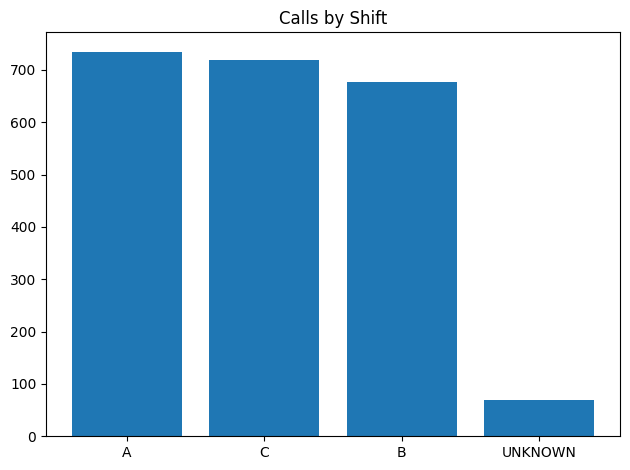

Busiest shift: A


In [39]:
# b.3) Busiest shift (A/B/C)
shift_counts = clean['_shift'].value_counts()
display(shift_counts.to_frame('count'))
plt.figure()
plt.bar(shift_counts.index.astype(str), shift_counts.values)
plt.title('Calls by Shift')
plt.tight_layout(); plt.show()
print('Busiest shift:', shift_counts.idxmax() if len(shift_counts) else 'N/A')

_dow,0,1,2,3,4,5,6,Total
_hour,,,,,,,,
0,8,7,5,2,3,7,4,36
1,9,10,7,8,4,7,10,55
2,5,4,3,3,3,8,10,36
3,9,9,9,1,10,5,7,50
4,3,4,5,2,7,6,4,31
5,9,3,6,5,5,3,7,38
6,5,5,7,7,11,7,9,51
7,14,15,9,10,14,5,11,78
8,13,14,18,10,7,6,14,82


Saved matrix CSV to C:\Users\wdinh\4-Module-Sequence-for-Applied-Deep-Learning\Quiz1\figs\q3_dow_hour_matrix.csv


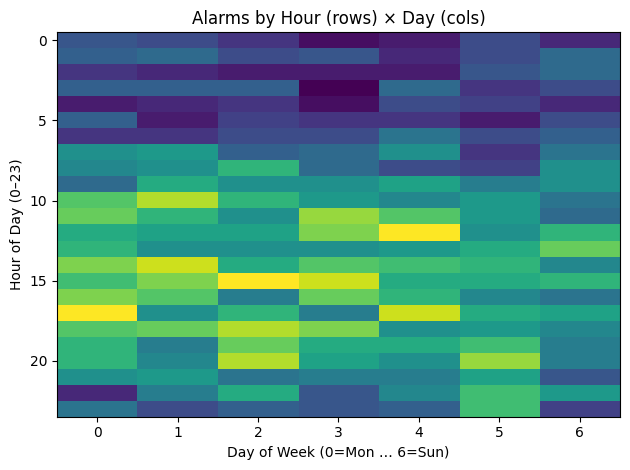

In [40]:
# b.4) Day-of-week × Hour matrix (based on ALARM time only)
subset = clean[clean['_created_ts'].notna()].copy()
subset['_dow']  = subset['_created_ts'].dt.dayofweek
subset['_hour'] = subset['_created_ts'].dt.hour
pivot = pd.pivot_table(subset, index='_hour', columns='_dow', values='_case_id', aggfunc='count', fill_value=0).sort_index()

if pivot.size == 0:
    print('No data to plot (empty pivot). Check that _created_ts parsed correctly.')
else:
    row_totals = pivot.sum(axis=1); col_totals = pivot.sum(axis=0); grand_total = int(pivot.values.sum())
    pivot_tot = pivot.copy(); pivot_tot['Total'] = row_totals
    pivot_tot.loc['Total'] = list(col_totals) + [grand_total]
    display(pivot_tot)
    pivot_tot.to_csv(FIG_DIR / 'q3_dow_hour_matrix.csv')
    print('Saved matrix CSV to', (FIG_DIR / 'q3_dow_hour_matrix.csv').resolve())
    plt.figure(); plt.imshow(pivot.values, aspect='auto');
    plt.title('Alarms by Hour (rows) × Day (cols)');
    plt.xlabel('Day of Week (0=Mon … 6=Sun)'); plt.ylabel('Hour of Day (0–23)');
    plt.tight_layout(); plt.show()

## (c) Unsupervised learning (two methods)

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Unified time feature: duration_hours if present else response_min/60
time_signal = clean['_duration_hours'].astype('float64')
fallback = (clean['_response_min'] / 60.0).astype('float64')
time_signal = time_signal.where(time_signal.notna(), fallback)

clean['_hour'] = clean['_created_ts'].dt.hour
clean['_dow']  = clean['_created_ts'].dt.dayofweek

feat_df = pd.DataFrame({
    'time_hours': time_signal,
    'units':      clean['_units'].astype('float64'),
    'hour':       clean['_hour'].astype('float64'),
    'dow':        clean['_dow'].astype('float64'),
}).dropna()

if len(feat_df) < 5:
    print('Not enough rows with features for clustering. Skipping clustering section.')
else:
    X = feat_df.values
    scaler = StandardScaler(); Xs = scaler.fit_transform(X)

    k_candidates = [2,3,4,5,6]
    sil_scores = {}; dbi_scores = {}; best_k = None; best_sil = -1
    for k in k_candidates:
        km = KMeans(n_clusters=k, n_init=10, random_state=42)
        labels = km.fit_predict(Xs)
        sil = silhouette_score(Xs, labels); dbi = davies_bouldin_score(Xs, labels)
        sil_scores[k] = sil; dbi_scores[k] = dbi
        if sil > best_sil: best_sil, best_k = sil, k
    print('KMeans silhouette by k:', sil_scores)
    print('KMeans DBI by k (lower better):', dbi_scores)

    km_best = KMeans(n_clusters=best_k, n_init=10, random_state=42)
    labels_km = km_best.fit_predict(Xs)
    sil_km = silhouette_score(Xs, labels_km); dbi_km = davies_bouldin_score(Xs, labels_km)
    print(f'KMeans → silhouette={sil_km:.3f}, DBI={dbi_km:.3f}')

    agg = AgglomerativeClustering(n_clusters=best_k)
    labels_agg = agg.fit_predict(Xs)
    sil_agg = silhouette_score(Xs, labels_agg); dbi_agg = davies_bouldin_score(Xs, labels_agg)
    print(f'Agglomerative → silhouette={sil_agg:.3f}, DBI={dbi_agg:.3f}')

    better = 'KMeans' if sil_km >= sil_agg else 'Agglomerative'
    print('Better method (by silhouette):', better)

    # Attach labels back to matching indices
    match_idx = feat_df.index
    clean_clusters = clean.loc[match_idx].copy()
    clean_clusters['_cluster'] = labels_km if better=='KMeans' else labels_agg
    display(clean_clusters.head())
    summary = clean_clusters.groupby('_cluster')[['_units','_hour','_dow']].agg(['mean','median','count'])
    display(summary)
    summary.to_csv(FIG_DIR / 'q3_cluster_summary.csv')
    print('Saved cluster summary to', (FIG_DIR / 'q3_cluster_summary.csv').resolve())

KMeans silhouette by k: {2: 0.23636958389162993, 3: 0.27021612300963543, 4: 0.28865825491911035, 5: 0.28716125382657715, 6: 0.27349864794027123}
KMeans DBI by k (lower better): {2: 1.698554534944344, 3: 1.2390823369320594, 4: 1.0619669968142855, 5: 0.9591183244982602, 6: 1.0021847613816457}
KMeans → silhouette=0.289, DBI=1.062
Agglomerative → silhouette=0.244, DBI=1.135
Better method (by silhouette): KMeans


,XREF ID,DISPATCH UNIT,DISPATCH CREATED DATE,INCIDENT NUMBER,1ST UNIT ON SCENE,ALARM DATE TIME,CALL COMPLETE,SHIFT,_created_ts,_closed_ts,_dispatch_ts,_units,_shift,_case_id,_duration_hours,_response_min,_hour,_dow,_cluster
0,2025107105,"BAT111, E171, LDR175",3/24/25 15:54,25-1368,BC-111,3/24/25 15:46,9/5/25 16:20,C,2025-03-24 15:46:00,2025-09-05 16:20:00,2025-03-24 15:54:00,3,C,2025107105,NaN,8.0,15.0,0.0,1
1,2025107223,BAT111,3/24/25 17:28,25-1369,BC-111,3/24/25 17:23,9/5/25 17:55,C,2025-03-24 17:23:00,2025-09-05 17:55:00,2025-03-24 17:28:00,1,C,2025107223,NaN,5.0,17.0,0.0,0
2,2025107415,E171,3/24/25 21:03,25-1370,E-171,3/24/25 21:02,9/4/25 21:09,C,2025-03-24 21:02:00,2025-09-04 21:09:00,2025-03-24 21:03:00,1,C,2025107415,NaN,1.0,21.0,0.0,0
3,2025107411,E171,3/24/25 21:03,25-1371,NaN,3/24/25 20:58,9/4/25 21:02,C,2025-03-24 20:58:00,2025-09-04 21:02:00,2025-03-24 21:03:00,1,C,2025107411,NaN,5.0,20.0,0.0,0
4,2025107384,"BAT111, E171, LDR175",3/24/25 21:43,25-1374,BC-111,3/24/25 20:30,9/4/25 21:36,C,2025-03-24 20:30:00,2025-09-04 21:36:00,2025-03-24 21:43:00,3,C,2025107384,NaN,73.0,20.0,0.0,3


_units                   _hour                   _dow             
              mean median count       mean median count      mean median count
_cluster                                                                      
0         1.233677    1.0   873  13.168385   14.0   873  0.982818    1.0   873
1         3.367925    3.0   212  13.471698   14.0   212  2.886792    3.0   212
2         1.226451    1.0  1051  13.373930   14.0  1051  4.456708    4.0  1051
3         1.263158    1.0    19  18.052632   21.0    19  3.421053    5.0    19

Saved cluster summary to C:\Users\wdinh\4-Module-Sequence-for-Applied-Deep-Learning\Quiz1\figs\q3_cluster_summary.csv


### Notes (write a few bullets under each section)
- **(a)** Issues found and cleaning decisions (assumptions/risks).
- **(b)** What the numbers/plots say about workload and shifts.
- **(c)** Which clustering method is better and how you would label clusters.
